# Make confidence interval for the ML parameter estimation of the generated data

In [1]:
import pandas as pd
import numpy as np
from src.data_generator import generate_default_buckets
from scipy.stats import norm

In [2]:
# Fix seed for reproducibility
seed = 2523
np.random.seed(seed)

In [3]:
factor_loading_list = [0.45, 0.45, 0.45]
pd_list = [0.0015, 0.0100, 0.0500]
gamma_list = norm.ppf(pd_list)
#num_of_obligors_list = [250, 250, 250]
num_of_obligors_list = [400, 250, 100]

# Make a pandas dataframe with Grade, Factor Loading, PD, Gamma, Num of Obligors
df = pd.DataFrame({'Grade': ['A', 'B', 'C'], 'Factor Loading': factor_loading_list, 'PD': pd_list, 'Gamma': gamma_list, 'Num of Obligors': num_of_obligors_list})
df

,Grade,Factor Loading,PD,Gamma,Num of Obligors
0,A,0.45,0.0015,-2.967738,400
1,B,0.45,0.0100,-2.326348,250
2,C,0.45,0.0500,-1.644854,100


In [4]:
length_of_time_series = 80
default_list = generate_default_buckets(factor_loading_list,num_of_obligors_list, gamma_list, time_points=length_of_time_series)
print("Number of defaults: ", default_list)
num_of_obligors_over_time = [x * length_of_time_series for x in num_of_obligors_list]
print("Number of obligors over time: ", num_of_obligors_over_time)

Number of defaults:  [23, 99, 260]
Number of obligors over time:  [32000, 20000, 8000]


In [11]:
# Empirical PD
empirical_pd_list = [x/y for x, y in zip(default_list, num_of_obligors_over_time)]
print("Empirical PD: ", empirical_pd_list)

Empirical PD:  [0.00303125, 0.01635, 0.060625]


In [6]:
gamma_list = [-2.9, -2.3, -1.6]
norm.cdf(gamma_list)

array([0.00186581, 0.01072411, 0.05479929])

In [5]:
from src.ML_estimation import calculate_my_likelihood_arr
from src.sucess_probability import p_g
from scipy.optimize import minimize

def parameter_estimation(default_list, num_of_obligors_over_time, factor_loading_init, gamma_list_init):
    initial_guess = gamma_list_init + factor_loading_init
    
    num_of_gamma = len(gamma_list_init)
    num_of_factor_loading = len(factor_loading_init)
    # bound = num_of_gamma * (-5, 5) + num_of_factor_loading * (-1, 1)
    bounds = num_of_gamma * [(-5, 5)] + num_of_factor_loading * [(-1, 1)]
    print(bounds)
    print(initial_guess)
    # Optimization
    objective_function = lambda params: -np.log(calculate_my_likelihood_arr(
        default_list, num_of_obligors_over_time, p_g, norm.pdf, np.repeat(params[3], 3), params[0:3]
    ))
    
    result = minimize(objective_function,
                  initial_guess,
                  method="Nelder-Mead",
                  bounds=bounds,
                  options={
                      'disp': True})
    
    return result

In [8]:
# Test the parameter estimation
factor_loading_init = [0.40]
gamma_list_init = [-2.9, -2.2, -1.6]
result = parameter_estimation(default_list, num_of_obligors_over_time, factor_loading_init, gamma_list_init)

[(-5, 5), (-5, 5), (-5, 5), (-1, 1)]
[-2.9, -2.2, -1.6, 0.4]
Optimization terminated successfully.
         Current function value: 11.014011
         Iterations: 249
         Function evaluations: 424


In [9]:
result.x[3]

1.1522589899534333e-05

In [10]:
# Confidence interval for the ML parameter estimation
list_of_len_ts = [20, 30, 80, 160]
num_of_simulations = 100

# Create a dictionary to store the results
# make the keys of the dictionary the length of the time series
results = {key: [] for key in list_of_len_ts}
for _ in range(num_of_simulations):
    for len_ts in list_of_len_ts:
        default_list = generate_default_buckets(factor_loading_list,num_of_obligors_list, gamma_list, time_points=len_ts)
        num_of_obligors_over_time = [x * len_ts for x in num_of_obligors_list]
        d_g_arr = np.array(default_list)
        n_g_arr = np.array(num_of_obligors_over_time)
        gamma_g = norm.ppf(d_g_arr / n_g_arr)
        initial_guess = np.array(gamma_g)
        initial_guess = np.append(initial_guess, 0.45)
        bounds = [(-5, 5), (-5, 5), (-5, 5), (-1, 1)]
        objective_function = lambda params: -np.log(calculate_my_likelihood_arr(d_g_arr, n_g_arr, p_g, norm.pdf, 
                                                                 np.repeat(params[3], 3), 
                                                                 params[0:3]))
        result = minimize(objective_function,
                  initial_guess,
                  method="Nelder-Mead",
                  bounds=bounds,
                  options={
                      'disp': False})
        results[len_ts].append(result.x[3])

KeyboardInterrupt: 

In [18]:
import csv

# Fájl neve, amibe kiírod
fajl_nev = "adatok.csv"

# Kiírás CSV-be
with open(fajl_nev, "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    for kulcs, ertek in results.items():
        csv_writer.writerow([kulcs, ertek])

In [35]:
import csv
file_name = "data_variable_change.csv"

return_data = {}
with open(file_name, "r", newline="") as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        return_data[row[0]] = row[1]

results = return_data

In [36]:
print(type(results))
print(results.keys())

<class 'dict'>
dict_keys(['100', '200', '300', '500'])


In [37]:
results

{'100': '[-3.954741676226937e-06, -4.169729787865443e-06, -2.2561185562170657e-05, 8.472309165690303e-06, -3.878210393467119e-05, 5.15501922976395e-06, 7.147475223844656e-06, 1.6333932857067317e-05, 2.4238871395438084e-05, -2.430668682814424e-06]',
 '200': '[0.2596942429758074, -1.9984866692475695e-05, -3.661882514874846e-05, 1.4336196733970221e-05, -1.173912710743653e-05, 0.46293277796209376, -4.1410029609961255e-06, -0.03478601988220862, 0.45471911255550934, -0.018755188533190692]',
 '300': '[0.44770750990613767, 0.46105002822318286, 0.038636172212812514, 0.44878729199229284, 0.4527353288824286, 0.3778998767705431, 0.4467530597305152, 0.45317294122015234, 0.45158992427371086, -7.511229378146125e-06]',
 '500': '[0.4525865380784997, 0.473848617511862, 0.46350575090299184, -0.0030051004515318177, -4.774504982658473e-06, 0.45142113909798204, 0.45260120468632203, 0.4377342192663827, 0.44703355663224165, 1.227431946423175e-05]'}

In [38]:
# A dictionary értékeinek átalakítása listákká
for key, value in results.items():
    # Eltávolítjuk a '[' és ']' karaktereket, majd szóközök mentén szétválasztjuk az elemeket
    value_list = value.strip('[]').split(', ')
    # Az így kapott stringeket int számmá alakítjuk
    value_list = [float(num_str) for num_str in value_list]
    # Az eredményt frissítjük az új listával
    results[key] = value_list

x = list(results.keys())
y_mean = [np.mean(results[key]) for key in x]

y_mean

[-1.0550821771944338e-06,
 0.11237467774528354,
 0.3578324621982398,
 0.3175733425539232]

In [ ]:
# To-do: make a module for optimization which gives back 2 list of parameters: one for the factor_loading and one for the gamma
# Then use these parameters to make the confidence interval, dict['len_ts']['grade']['factor_loading'] = list of factor_loadings
# Make it with MM and 3 type ML

In [6]:
import numpy as np
from src.ML_estimation import gen_data_and_mle

In [7]:
#np.random.seed(42)
np.random.seed(8496315)
time_horizon = 40
factor_loading_list = [0.45, 0.45, 0.45]
num_of_obligors_list = [3000, 3000, 3000]
gamma_list = [-2.9, -2.3, -1.6]
factor_loading_init = [0.447]
gamma_list_init = [-2.91, -2.29, -1.603]

In [22]:
results_20 = {}

for i in range(100):
    temp_result_20 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_20[i] = temp_result_20

C:\Users\kissp\PycharmProjects\VasicekPDModell\src\ML_estimation.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(integrand, -3, 3)


In [23]:
results_30 = {}

for i in range(100):
    temp_result_30 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_30[i] = temp_result_30

In [24]:
results_80 = {}

for j in range(100):
    temp_result_80 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_80[j] = temp_result_80

In [25]:
results_160 = {}

for k in range(100):
    temp_result_160 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_160[k] = temp_result_160

In [26]:
existing_20_df = pd.read_csv("data\conf_interval_data_20_same_w.csv", index_col=0)
existing_20_df.tail(10)

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
190,216,1320,6698,120000,120000,120000,-2.797646,-2.249678,-1.643216,0.465721
191,223,1377,6640,120000,120000,120000,-2.823872,-2.246843,-1.644241,0.461544
192,164,988,5660,120000,120000,120000,-2.811062,-2.276968,-1.629751,0.453023
193,203,1164,6205,120000,120000,120000,-2.842005,-2.296124,-1.682964,0.442837
194,239,1384,7326,120000,120000,120000,-2.879473,-2.272323,-1.546028,0.000012
195,162,1014,5760,120000,120000,120000,-2.863681,-2.308688,-1.647753,0.405646
196,270,1566,7728,120000,120000,120000,-2.826945,-2.283652,-1.648820,0.454415
197,337,1937,9239,120000,120000,120000,-2.876994,-2.302514,-1.654026,0.453651
198,231,1275,6088,120000,120000,120000,-2.827986,-2.261398,-1.683086,0.449559
199,105,653,4091,120000,120000,120000,-2.796668,-2.273428,-1.626133,0.445532


In [29]:
import pandas as pd
existing_df = pd.read_csv("data\conf_interval_data_20_same_w.csv", index_col=0)
df_20 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_20.loc[i, "n_1"] = list(results_20.values())[i][0][0]
    df_20.loc[i, "n_2"] = list(results_20.values())[i][0][1]
    df_20.loc[i, "n_3"] = list(results_20.values())[i][0][2]
    df_20.loc[i, "d_1"] = list(results_20.values())[i][1][0]
    df_20.loc[i, "d_2"] = list(results_20.values())[i][1][1]
    df_20.loc[i, "d_3"] = list(results_20.values())[i][1][2]
    df_20.loc[i, "gamma_1"] = list(results_20.values())[i][2][0]
    df_20.loc[i, "gamma_2"] = list(results_20.values())[i][2][1]
    df_20.loc[i, "gamma_3"] = list(results_20.values())[i][2][2]
    df_20.loc[i, "factor_loading"] = list(results_20.values())[i][2][3]

extended_df = pd.concat([existing_df, df_20], ignore_index=True)
extended_df.to_csv("data\conf_interval_data_20_same_w.csv")

extended_df.tail(10)

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
290,174,1042,5962,120000,120000,120000,-2.862432,-2.326395,-1.684176,0.444175
291,282,1430,7034,120000,120000,120000,-2.836134,-2.32367,-1.697073,0.42803
292,153,1031,5833,120000,120000,120000,-2.842248,-2.27233,-1.6239,0.444437
293,213,1172,6107,120000,120000,120000,-2.836808,-2.321579,-1.672712,0.447233
294,261,1462,7611,120000,120000,120000,-2.842269,-2.323563,-1.653459,0.446527
295,210,1340,6901,120000,120000,120000,-2.838517,-2.268544,-1.627792,0.454844
296,209,1244,6451,120000,120000,120000,-2.858128,-2.287541,-1.651912,0.455726
297,157,1146,5841,120000,120000,120000,-2.88964,-2.29149,-1.693916,0.446877
298,103,695,4635,120000,120000,120000,-2.893025,-2.33821,-1.651857,0.421015
299,262,1500,7845,120000,120000,120000,-2.847402,-2.293668,-1.634097,0.455534


In [31]:
existing_30_df = pd.read_csv("data\conf_interval_data_30_same_w.csv", index_col=0)

df_30 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_30.loc[i, "n_1"] = list(results_30.values())[i][0][0]
    df_30.loc[i, "n_2"] = list(results_30.values())[i][0][1]
    df_30.loc[i, "n_3"] = list(results_30.values())[i][0][2]
    df_30.loc[i, "d_1"] = list(results_30.values())[i][1][0]
    df_30.loc[i, "d_2"] = list(results_30.values())[i][1][1]
    df_30.loc[i, "d_3"] = list(results_30.values())[i][1][2]
    df_30.loc[i, "gamma_1"] = list(results_30.values())[i][2][0]
    df_30.loc[i, "gamma_2"] = list(results_30.values())[i][2][1]
    df_30.loc[i, "gamma_3"] = list(results_30.values())[i][2][2]
    df_30.loc[i, "factor_loading"] = list(results_30.values())[i][2][3]

extended_df = pd.concat([existing_30_df, df_30], ignore_index=True)
extended_df.to_csv("data\conf_interval_data_30_same_w.csv")

extended_df.tail(10)

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
290,173,1224,6008,120000,120000,120000,-2.845505,-2.296881,-1.683069,0.439687
291,207,1275,6618,120000,120000,120000,-2.851988,-2.269011,-1.647063,0.45872
292,213,1206,6469,120000,120000,120000,-2.817576,-2.285108,-1.660826,0.459595
293,104,849,4761,120000,120000,120000,-3.13255,-2.453427,-1.754477,-0.00001
294,210,1388,6978,120000,120000,120000,-2.988355,-2.367988,-1.69789,0.2955
295,176,1052,5766,120000,120000,120000,-2.852741,-2.305079,-1.656998,0.410956
296,192,1072,6119,120000,120000,120000,-2.900978,-2.329295,-1.685799,0.430066
297,249,1301,6487,120000,120000,120000,-2.804006,-2.257535,-1.647701,0.46163
298,249,1321,6410,120000,120000,120000,-2.781491,-2.266393,-1.64475,0.454648
299,269,1575,6998,120000,120000,120000,-2.838565,-2.267956,-1.697356,0.446497


In [32]:
existing_80_df = pd.read_csv("data\conf_interval_data_80_same_w.csv", index_col=0)

df_80 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_80.loc[i, "n_1"] = list(results_80.values())[i][0][0]
    df_80.loc[i, "n_2"] = list(results_80.values())[i][0][1]
    df_80.loc[i, "n_3"] = list(results_80.values())[i][0][2]
    df_80.loc[i, "d_1"] = list(results_80.values())[i][1][0]
    df_80.loc[i, "d_2"] = list(results_80.values())[i][1][1]
    df_80.loc[i, "d_3"] = list(results_80.values())[i][1][2]
    df_80.loc[i, "gamma_1"] = list(results_80.values())[i][2][0]
    df_80.loc[i, "gamma_2"] = list(results_80.values())[i][2][1]
    df_80.loc[i, "gamma_3"] = list(results_80.values())[i][2][2]
    df_80.loc[i, "factor_loading"] = list(results_80.values())[i][2][3]

extended_df = pd.concat([existing_80_df, df_80], ignore_index=True)
extended_df.to_csv("data\conf_interval_data_80_same_w.csv")

In [33]:
existing_160_df = pd.read_csv("data\conf_interval_data_160_same_w.csv", index_col=0)

df_160 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_160.loc[i, "n_1"] = list(results_160.values())[i][0][0]
    df_160.loc[i, "n_2"] = list(results_160.values())[i][0][1]
    df_160.loc[i, "n_3"] = list(results_160.values())[i][0][2]
    df_160.loc[i, "d_1"] = list(results_160.values())[i][1][0]
    df_160.loc[i, "d_2"] = list(results_160.values())[i][1][1]
    df_160.loc[i, "d_3"] = list(results_160.values())[i][1][2]
    df_160.loc[i, "gamma_1"] = list(results_160.values())[i][2][0]
    df_160.loc[i, "gamma_2"] = list(results_160.values())[i][2][1]
    df_160.loc[i, "gamma_3"] = list(results_160.values())[i][2][2]
    df_160.loc[i, "factor_loading"] = list(results_160.values())[i][2][3]

extended_df = pd.concat([existing_160_df, df_160], ignore_index=True)
extended_df.to_csv("data\conf_interval_data_160_same_w.csv")

In [34]:
extended_df.tail(10)

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
290,253,1326,6543,120000,120000,120000,-2.748469,-2.253055,-1.630937,0.466389
291,99,833,5226,120000,120000,120000,-3.021904,-2.379143,-1.678434,0.353716
292,282,1535,7445,120000,120000,120000,-2.811173,-2.28102,-1.661384,0.452165
293,189,1156,5996,120000,120000,120000,-2.865464,-2.287224,-1.681881,0.448581
294,327,1453,6431,120000,120000,120000,-2.840548,-2.345633,-1.740361,0.334897
295,424,1866,8163,120000,120000,120000,-2.799922,-2.297619,-1.71861,0.444854
296,203,1145,5968,120000,120000,120000,-2.845962,-2.324693,-1.706906,0.428543
297,230,1348,6826,120000,120000,120000,-2.829324,-2.241411,-1.628126,0.451796
298,264,1612,7732,120000,120000,120000,-2.846367,-2.2843,-1.65884,0.449111
299,273,1621,8196,120000,120000,120000,-2.831008,-2.271387,-1.632412,0.460042


In [37]:
results = {20: [value[2][3] for value in list(results_20.values())],
           30: [value[2][3] for value in list(results_30.values())],
           80: [value[2][3] for value in list(results_80.values())],
           160: [value[2][3] for value in list(results_160.values())]}

In [38]:
results

{20: [0.439793506588386,
  0.44428889461709153,
  0.4034438878579114,
  2.4705012819735963e-05,
  0.4535506333484097,
  0.4358467126506459,
  0.44559408975339226,
  0.45074402109102363,
  0.30470014117562744,
  0.44926204467541386,
  0.45708440964449004,
  0.35589583196893915,
  0.2088096182082098,
  0.33662903093364116,
  0.45629205284481217,
  0.42600410488267715,
  0.44697862481957434,
  0.4640576220295411,
  0.4440822630873029,
  0.14240612987378826,
  0.41600101799795464,
  0.44922692483831306,
  0.4179490679767993,
  0.45919627448981715,
  0.4560340797634846,
  -2.237709777935266e-06,
  0.4351252588412706,
  0.45268431090116834,
  0.4470947904776913,
  0.4275583535591716,
  0.45222118695306307,
  0.42058460039321455,
  0.3438943023940006,
  0.44185530698323466,
  0.4484239840783999,
  0.45248540793206693,
  0.42950320780969586,
  0.45660088046974756,
  0.42377009053898856,
  0.43783053983542347,
  0.4627095342018967,
  0.4470540135396209,
  0.4461457867587041,
  0.421870439757979

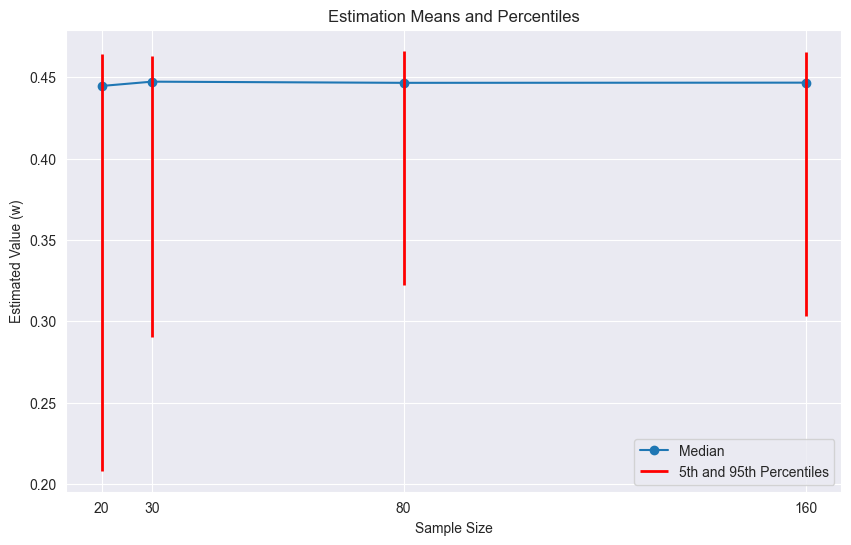

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Calculating averages
x = list(results.keys())
y_mean = [np.median(results[key]) for key in x]

# Calculating percentiles
y_5th = [np.percentile(results[key], 5) for key in x]
y_95th = [np.percentile(results[key], 95) for key in x]

# Creating the plot
plt.figure(figsize=(10, 6))

# Plotting means
plt.plot(x, y_mean, marker='o', linestyle='-')

# Plotting 5th and 95th percentiles
for i in range(len(x)):
    plt.vlines(x[i], y_5th[i], y_95th[i], colors='r', linestyles='solid', linewidth=2)

# Formatting the plot
plt.title('Estimation Means and Percentiles')
plt.xlabel('Sample Size')
plt.ylabel('Estimated Value (w)')
plt.grid(True)
plt.xticks(x)
plt.legend(['Median', '5th and 95th Percentiles'], loc='lower right')

# Displaying the plot
plt.show()